In [82]:
library(rhdf5)
library(MASS)
library(BoutrosLab.plotting.general)

Loading required package: lattice

Loading required package: latticeExtra

Loading required package: cluster

Loading required package: hexbin

Loading required package: grid


Attaching package: ‘BoutrosLab.plotting.general’


The following object is masked from ‘package:stats’:

    dist




# Test reading h5 and accessing data

In [3]:
fh <- "/iblm/netapp/home/karthik/crisprQTL/simulated_data/sim.h5"

Get internal structure of h5 file

In [11]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_DATASET,INTEGER,13000 x 50000
2,/,guides,H5I_GROUP,,
3,/guides,metadata,H5I_DATASET,COMPOUND,2000
4,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
5,/,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000
6,/,mu,H5I_DATASET,FLOAT,13000 x 50000
7,/,scaling_factors,H5I_DATASET,FLOAT,50000
8,/,x,H5I_GROUP,,


In [21]:
# read in mu values
mu.values <- h5read(file = fh, name = 'mu')

In [37]:
max(mu.values[11331, ])

ERROR: Error in mu.values[11331, "linear_predictor"]: no 'dimnames' attribute for array


In [38]:
beta1.values <- h5read(file = fh, name = 'linear_predictor')

In [47]:
which(beta1.values[11331, ] == max(beta1.values[11331, ]))

[1] 38609

In [41]:
coeffs[11331, ]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11331,1.408948,-2.852283,1.852508,6.949296,5.034739


In [48]:
cell.cycle.scores[38609, ]

,s.scores,g2m.scores
,<dbl>,<dbl>
38609,-2.823965,4.064184


In [49]:
scaling.factors[38609]

[1] 0.049655

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [4]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")

In [5]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,3683,0.7247283,-4.462767
2,1175,0.6302226,-4.838250
3,11331,0.5332885,-2.852283
4,1399,0.6552179,-2.778439
5,543,0.6759810,-3.910947
6,10902,0.5953462,-2.812525


# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene with `glm.nb` (MASS library)

In [14]:
test.gene <- 3683

obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

In [15]:
head(gene.data)

,guide.eff,s.score,g2m.score,counts,scaling.factor
,<int>,<dbl>,<dbl>,<int>,<dbl>
1,0,-1.0309103,1.1526160,0,0.050330
2,0,-0.4639413,1.2934445,1,0.050077
3,0,0.5149060,-0.4730435,0,0.049864
4,0,-0.9497266,0.3118649,0,0.050117
5,0,1.2838343,-2.2465534,0,0.050016
6,0,-0.7403177,0.4665516,0,0.049508


In [16]:
unique(gene.data$guide.eff)

[1] 0 1

In [17]:
ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), data = gene.data)

In [18]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), 
    data = gene.data, init.theta = 1.513933735, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8242  -0.5363  -0.1985  -0.0394   4.1341  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.85635    0.01464   58.49   <2e-16 ***
guide.eff   -4.16329    0.27430  -15.18   <2e-16 ***
s.score      5.30530    0.01828  290.18   <2e-16 ***
g2m.score    3.21472    0.01469  218.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5139) family taken to be 1)

    Null deviance: 493207  on 49999  degrees of freedom
Residual deviance:  27100  on 49996  degrees of freedom
AIC: 105755

Number of Fisher Scoring iterations: 1


              Theta:  1.5139 
          Std. Err.:  0.0237 

 2 x log-likelihood:  -105744.9340 

In [19]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3683,0.780297,-4.462767,5.321519,3.227325,1.829826


# Test for all target genes

E.g. the 1000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [60]:
counts.matrix <- h5read(file = fh, name = "counts")

In [61]:
head(counts.matrix)

0,1,1,0,11,0,0,0,0,0,⋯,8058,1,1,0,0,1,6,0,1,0
7097,58161,300,276,3,598,749,14586,1039,1686,⋯,2829,2612,411,4337,148,2257,100,5542,6,8030
0,1,1,0,0,0,0,0,0,0,⋯,257,2,0,1,0,0,10,0,0,3
1,9,0,0,0,0,4,5,0,0,⋯,1,3,0,23,0,0,2,1,0,0
0,3,0,0,0,0,0,0,1,0,⋯,7,1,0,0,0,0,2,0,0,1
0,2,1,0,1,1,1,0,0,2,⋯,627,3,0,0,0,0,21,0,0,2


In [110]:
scaling.factors <- colSums(counts.matrix) / 0.0001

In [ ]:
scaling.factors

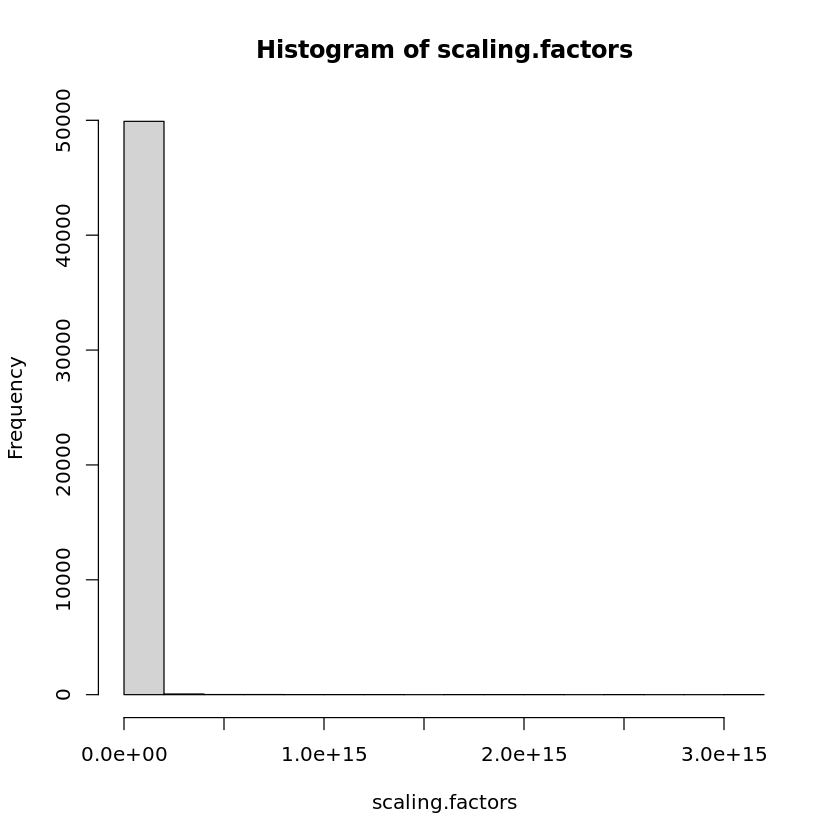

In [111]:
hist(scaling.factors)

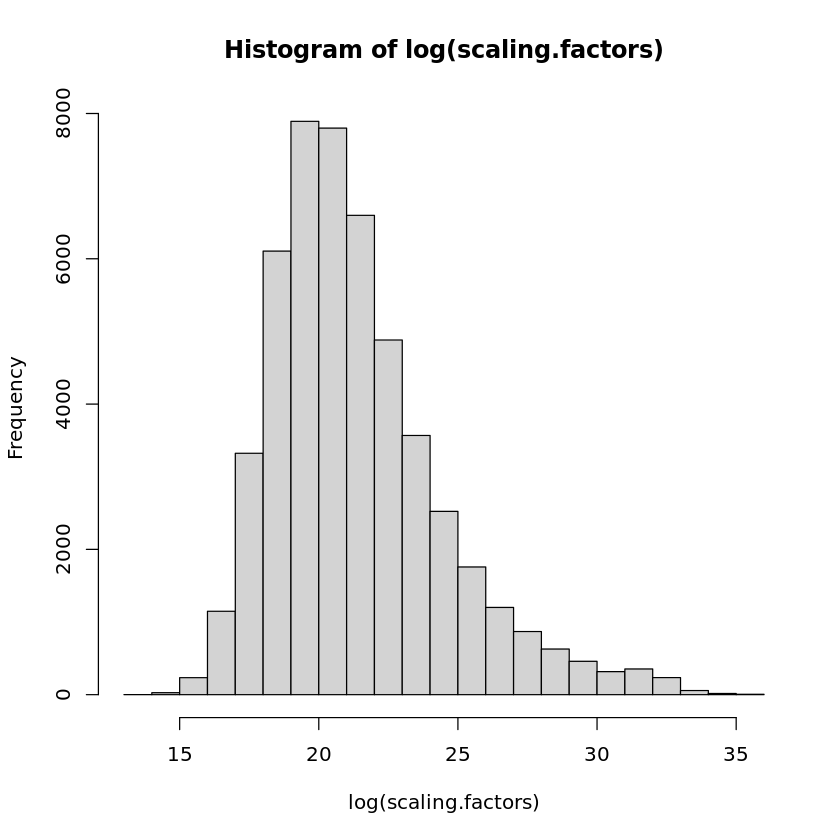

In [112]:
hist(log(scaling.factors))

In [75]:
sum(is.na(log(scaling.factors)))

[1] 0

In [76]:
length(scaling.factors)

[1] 50000

In [113]:
ml.list <- list()

for (gene in guides.metadata$target.gene[1:10]) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factors = scaling.factors)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factors)), data = gene.data)
    ml.list[[gene]] <- ml
}

[1] 3683


ERROR: Error in glm.fitter(x = X, y = Y, w = w, etastart = eta, offset = offset, : NA/NaN/Inf in 'x'


In [54]:
summary(ml.list[[3683]])


Call:
glm.nb(formula = counts ~ guide.eff, data = gene.data, init.theta = 0.05211118873, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8130  -0.8130  -0.8130  -0.4996  30.4046  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.38511    0.01965  172.27   <2e-16 ***
guide.eff   -3.20122    0.30722  -10.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0521) family taken to be 1)

    Null deviance: 29512  on 49999  degrees of freedom
Residual deviance: 29463  on 49998  degrees of freedom
AIC: 172119

Number of Fisher Scoring iterations: 1


              Theta:  0.052111 
          Std. Err.:  0.000467 

 2 x log-likelihood:  -172112.870000 

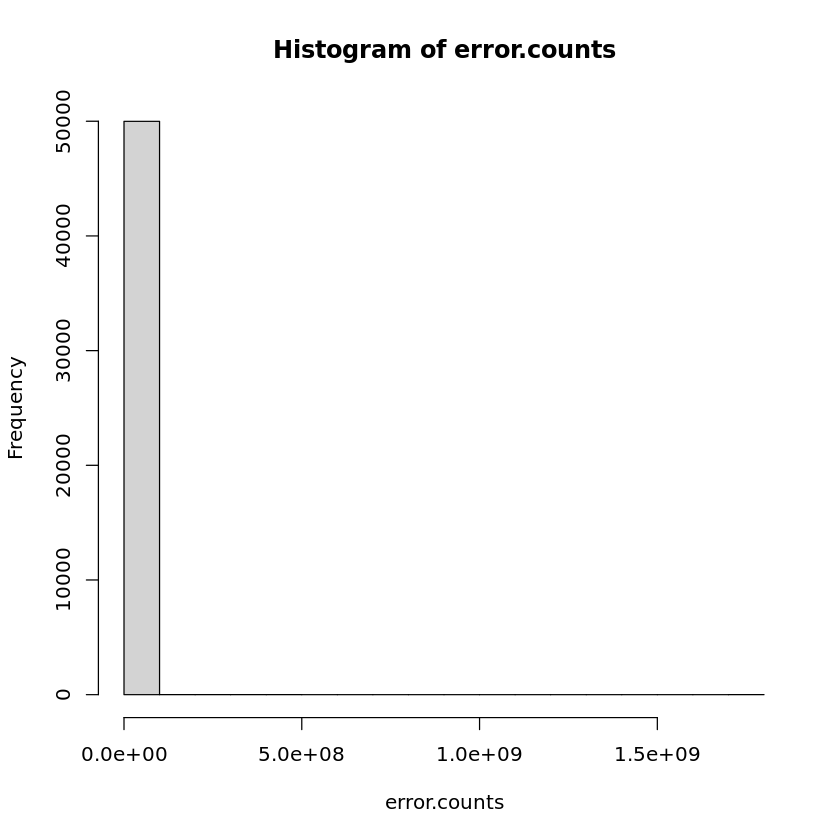

In [22]:
error.counts <- h5read(file = fh, name = "counts", index = list(11331, 1:50000))
max(error.counts)

In [33]:
max(error.counts)

[1] 1760440863

In [92]:
test.df <- data.frame(cbind(counts.matrix[3683, ], scaling.factors))
colnames(test.df) <- c('count', 'scaling.factor')
head(test.df)

,count,scaling.factor
,<dbl>,<dbl>
1,0,0.444139
2,1,3.763414
3,0,0.056302
4,0,0.009779
5,0,0.106756
6,0,0.024059


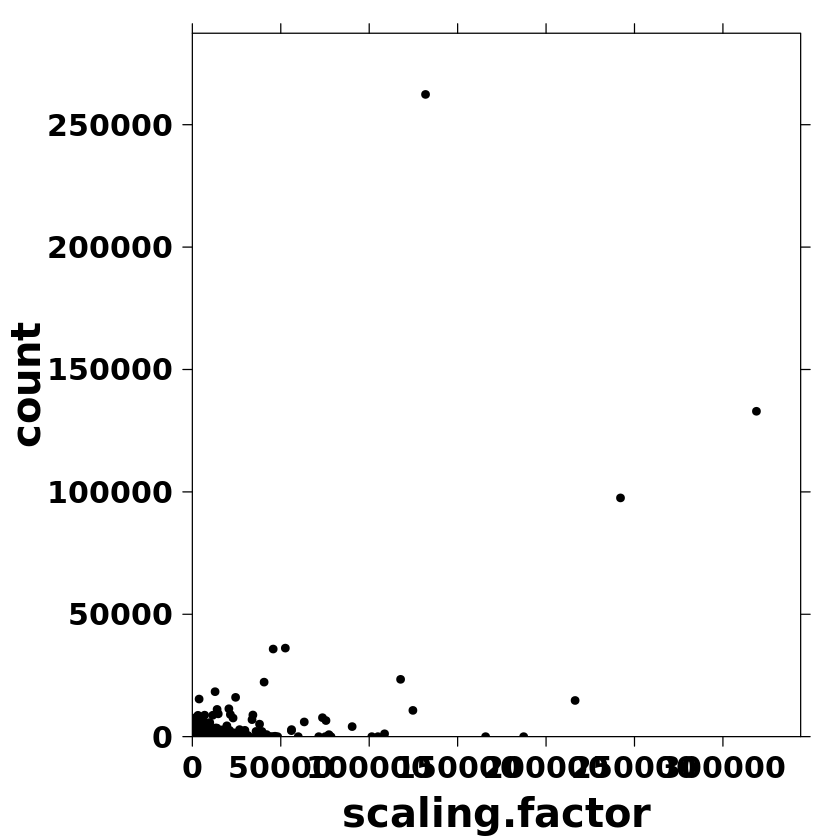

In [94]:
create.scatterplot(
    formula = count ~ scaling.factor,
    data = test.df,
)

In [101]:
log(max(scaling.factors))

[1] 12.67279

In [87]:
nrow(counts.matrix)

[1] 13000